In [ ]:
def sequence_split_x_y(sequence, window_size):
    sequences_x = []
    sequences_y = []
    for i in range(len(sequence)):
        if i + window_size > len(sequence) - 1:
            break
        sequences_x.append(sequence[i:i + window_size])
        sequences_y.append(sequence[i + window_size])
    return sequences_x, sequences_y

In [ ]:
import numpy as np

sequence = np.arange(10)
print(sequence)
train_x, train_y = sequence_split_x_y(sequence, 3)
train_x = np.array(train_x)
train_y = np.array(train_y)
print(train_x, train_y)

[0 1 2 3 4 5 6 7 8 9]
[[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]
 [6 7 8]] [3 4 5 6 7 8 9]


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D

# 该该函数将序列数据分割成样本
# def split_sequence(sequence, sw_width, n_features):
#     '''
#     这个简单的示例，通过for循环实现有重叠截取数据，滑动步长为1，滑动窗口宽度为sw_width。
#     以后的文章，会介绍使用yield方法来实现特定滑动步长的滑动窗口的实例。
#     '''
#     X, y = [], []
    
#     for i in range(len(sequence)):
#         # 获取单个样本中最后一个元素的索引，因为python切片前闭后开，索引从0开始，所以不需要-1
#         end_element_index = i + sw_width
#         # 如果样本最后一个元素的索引超过了序列索引的最大长度，说明不满足样本元素个数，则这个样本丢弃
#         if end_element_index > len(sequence) - 1:
#             break
#         # 通过切片实现步长为1的滑动窗口截取数据组成样本的效果
#         seq_x, seq_y = sequence[i:end_element_index], sequence[end_element_index]
        
#         X.append(seq_x)
#         y.append(seq_y)
        
#         process_X, process_y = np.array(X), np.array(y)
#         process_X = process_X.reshape((process_X.shape[0], process_X.shape[1], n_features))
    
#     print('split_sequence:\nX:\n{}\ny:\n{}\n'.format(np.array(X), np.array(y)))
#     print('X_shape:{},y_shape:{}\n'.format(np.array(X).shape, np.array(y).shape))
#     print('train_X:\n{}\ntrain_y:\n{}\n'.format(process_X, process_y))
#     print('train_X.shape:{},trian_y.shape:{}\n'.format(process_X.shape, process_y.shape))
#     return process_X, process_y

    
def oned_cnn_model(sw_width, n_features, X, y, test_X, epoch_num, verbose_set):
    model = Sequential()
    
    # 对于一维卷积来说，data_format='channels_last'是默认配置，该API的规则如下：
    # 输入形状为：(batch, steps, channels)；输出形状为：(batch, new_steps, filters)，padding和strides的变化会导致new_steps变化
    # 如果设置为data_format = 'channels_first'，则要求输入形状为： (batch, channels, steps).
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu',
                     strides=1, padding='valid', data_format='channels_last',
                     input_shape=(sw_width, n_features)))
    
    # 对于一维池化层来说，data_format='channels_last'是默认配置，该API的规则如下：
    # 3D 张量的输入形状为: (batch_size, steps, features)；输出3D张量的形状为：(batch_size, downsampled_steps, features)
    # 如果设置为data_format = 'channels_first'，则要求输入形状为：(batch_size, features, steps)
    model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid', 
                           data_format='channels_last')) 
    
    # data_format参数的作用是在将模型从一种数据格式切换到另一种数据格式时保留权重顺序。默认为channels_last。
    # 如果设置为channels_last，那么数据输入形状应为：（batch，…，channels）；如果设置为channels_first，那么数据输入形状应该为（batch，channels，…）
    # 输出为（batch, 之后参数尺寸的乘积）
    model.add(Flatten())
    
    # Dense执行以下操作：output=activation（dot（input，kernel）+bias），
    # 其中,activation是激活函数，kernel是由层创建的权重矩阵，bias是由层创建的偏移向量（仅当use_bias为True时适用）。
    # 2D 输入：(batch_size, input_dim)；对应 2D 输出：(batch_size, units)
    model.add(Dense(units=50, activation='relu',
                use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros',))
    
    # 因为要预测下一个时间步的值，因此units设置为1
    model.add(Dense(units=1))
    
    # 配置模型
    model.compile(optimizer='adam', loss='mse',
                 metrics=['accuracy'], loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
    
    print('\n',model.summary())
    # X为输入数据，y为数据标签；batch_size：每次梯度更新的样本数，默认为32。
    # verbose: 0,1,2. 0=训练过程无输出，1=显示训练过程进度条，2=每训练一个epoch打印一次信息
    
    history = model.fit(X, y, batch_size=32, epochs=epoch_num, verbose=verbose_set)
    
    return model, history
def model_predict(model, test_X, test_Y):
    yhat = model.predict(test_X, verbose=0)
    print('\nyhat:', yhat)
    print(model.evaluate(test_X, test_Y))


n_features = 0
epoch_num = 1000
verbose_set = 1
sw_width = 3

# 预测
x_input = np.array([7, 8, 9])
y_input = np.array([10])
x_input = x_input.reshape((1, sw_width, n_features))
print(x_input)
model, history = oned_cnn_model(sw_width, n_features, train_x, train_y, x_input, epoch_num, verbose_set)

print('\ntrain_acc:%s'%np.mean(history.history['accuracy']), '\ntrain_loss:%s'%np.mean(history.history['loss']))


In [ ]:
model_predict(model, x_input, y_input)


yhat: [[10.079639]]
1/1 [==============================] - 0s 186ms/step - loss: 0.0063 - accuracy: 0.0000e+00
[0.006342439446598291, 0.0]


In [ ]:
import torch
from torch import nn

In [ ]:
class LstmRNN(nn.Module):
  def __init__(self, input_size, hidden_size=1, output_size=1, num_layers=1):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
    self.linear1 = nn.Linear(hidden_size, output_size)

  def forward(self, _x):
    x, _ = self.lstm(_x)
    s, b, h = x.shape # x为输出，shape(seq_len, batch, hidden_size)
    x = x.view(s*b, h)
    x = self.linear1(x)
    x= x.view(s, b, -1)
    return x

In [ ]:
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('在GPU上训练')
else:
  print('无GPU，在CPU上训练')



在GPU上训练


In [ ]:
import numpy as np
# 创建数据集
data_len = 200
t = np.linspace(0, 12*np.pi, data_len)
sin_t = np.sin(t)
cos_t = np.cos(t)

dataset = np.zeros((data_len,2))
dataset[:,0] = sin_t
dataset[:,1] = cos_t
dataset = dataset.astype('float32')
print(dataset.shape)

(200, 2)


In [ ]:
print(t[:60])

[ 0.          0.18944277  0.37888555  0.56832832  0.75777109  0.94721387
  1.13665664  1.32609941  1.51554218  1.70498496  1.89442773  2.0838705
  2.27331328  2.46275605  2.65219882  2.8416416   3.03108437  3.22052714
  3.40996992  3.59941269  3.78885546  3.97829823  4.16774101  4.35718378
  4.54662655  4.73606933  4.9255121   5.11495487  5.30439765  5.49384042
  5.68328319  5.87272597  6.06216874  6.25161151  6.44105428  6.63049706
  6.81993983  7.0093826   7.19882538  7.38826815  7.57771092  7.7671537
  7.95659647  8.14603924  8.33548202  8.52492479  8.71436756  8.90381033
  9.09325311  9.28269588  9.47213865  9.66158143  9.8510242  10.04046697
 10.22990975 10.41935252 10.60879529 10.79823807 10.98768084 11.17712361]


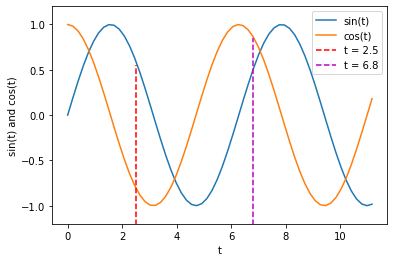

In [ ]:
# plot
import matplotlib.pyplot as plt
plt.figure()
plt.plot(t[0:60], dataset[0:60,0], label = 'sin(t)')
plt.plot(t[0:60], dataset[0:60,1], label = 'cos(t)')
plt.plot([2.5, 2.5], [-1.3, 0.55], 'r--', label='t = 2.5') # t = 2.5
plt.plot([6.8, 6.8], [-1.3, 0.85], 'm--', label='t = 6.8') # t = 6.8
plt.xlabel('t')
plt.ylim(-1.2, 1.2)
plt.ylabel('sin(t) and cos(t)')
plt.legend(loc='upper right')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf /content/drive/MyDrive/vgg16-dataset/test/.ipynb_checkpoints
!ls -lah /content/drive/MyDrive/vgg16-dataset/test

total 8.0K
drwx------ 2 root root 4.0K Mar 17 08:21 puzzle
drwx------ 2 root root 4.0K Mar 17 08:12 tiger


In [ ]:
import torch
import torch.nn as tnn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import os

os.chdir('/content/drive/MyDrive/vgg16-dataset')

BATCH_SIZE = 10
LEARNING_RATE = 0.01
EPOCH = 50
N_CLASSES = 2  # 类别数量

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                         std  = [ 0.229, 0.224, 0.225 ]),
    ])

trainData = dsets.ImageFolder('./train', transform)
testData = dsets.ImageFolder('./test', transform)

trainLoader = torch.utils.data.DataLoader(dataset=trainData, batch_size=BATCH_SIZE, shuffle=True)
testLoader = torch.utils.data.DataLoader(dataset=testData, batch_size=BATCH_SIZE, shuffle=False)

def conv_layer(chann_in, chann_out, k_size, p_size):
    layer = tnn.Sequential(
        tnn.Conv2d(chann_in, chann_out, kernel_size=k_size, padding=p_size),
        tnn.BatchNorm2d(chann_out),
        tnn.ReLU()
    )
    return layer

def vgg_conv_block(in_list, out_list, k_list, p_list, pooling_k, pooling_s):

    layers = [ conv_layer(in_list[i], out_list[i], k_list[i], p_list[i]) for i in range(len(in_list)) ]
    layers += [ tnn.MaxPool2d(kernel_size = pooling_k, stride = pooling_s)]
    return tnn.Sequential(*layers)

def vgg_fc_layer(size_in, size_out):
    layer = tnn.Sequential(
        tnn.Linear(size_in, size_out),
        tnn.BatchNorm1d(size_out),
        tnn.ReLU()
    )
    return layer

class VGG16(tnn.Module):
    def __init__(self, n_classes=1000):
        super(VGG16, self).__init__()

        # Conv blocks (BatchNorm + ReLU activation added in each block)
        self.layer1 = vgg_conv_block([3,64], [64,64], [3,3], [1,1], 2, 2)
        self.layer2 = vgg_conv_block([64,128], [128,128], [3,3], [1,1], 2, 2)
        self.layer3 = vgg_conv_block([128,256,256], [256,256,256], [3,3,3], [1,1,1], 2, 2)
        self.layer4 = vgg_conv_block([256,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)
        self.layer5 = vgg_conv_block([512,512,512], [512,512,512], [3,3,3], [1,1,1], 2, 2)

        # FC layers
        self.layer6 = vgg_fc_layer(7*7*512, 4096)
        self.layer7 = vgg_fc_layer(4096, 4096)

        # Final layer
        self.layer8 = tnn.Linear(4096, n_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        vgg16_features = self.layer5(out)
        out = vgg16_features.view(out.size(0), -1)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)

        return vgg16_features, out

      
vgg16 = VGG16(n_classes=N_CLASSES)
vgg16.cuda()

# Loss, Optimizer & Scheduler
cost = tnn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Train the model
for epoch in range(EPOCH):

    avg_loss = 0
    cnt = 0
    for images, labels in trainLoader:
        images = images.cuda()
        labels = labels.cuda()

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        _, outputs = vgg16(images)
        loss = cost(outputs, labels)
        avg_loss += loss.data
        cnt += 1
        print("[E: %d] loss: %f, avg_loss: %f" % (epoch, loss.data, avg_loss/cnt))
        loss.backward()
        optimizer.step()
    scheduler.step(avg_loss)

# Test the model
vgg16.eval()  # 进行模型评估，不改变权重
correct = 0
total = 0

for images, labels in testLoader:
    images = images.cuda()
    _, outputs = vgg16(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()
    print(predicted, labels, correct, total)
    print("avg acc: %f" % (100* correct/total))

# Save the Trained Model
torch.save(vgg16.state_dict(), 'cnn.pkl')

[E: 0] loss: 0.602918, avg_loss: 0.602918
[E: 1] loss: 19.585896, avg_loss: 19.585896
[E: 2] loss: 0.000000, avg_loss: 0.000000
[E: 3] loss: 40.544327, avg_loss: 40.544327
[E: 4] loss: 0.000000, avg_loss: 0.000000
[E: 5] loss: 26.722561, avg_loss: 26.722561
[E: 6] loss: 0.000019, avg_loss: 0.000019
[E: 7] loss: 0.000003, avg_loss: 0.000003
[E: 8] loss: 0.000192, avg_loss: 0.000192
[E: 9] loss: 0.028656, avg_loss: 0.028656
[E: 10] loss: 15.622988, avg_loss: 15.622988
[E: 11] loss: 2.348677, avg_loss: 2.348677
[E: 12] loss: 0.000000, avg_loss: 0.000000
[E: 13] loss: 5.455351, avg_loss: 5.455351
[E: 14] loss: 0.000000, avg_loss: 0.000000
[E: 15] loss: 61.467064, avg_loss: 61.467064
[E: 16] loss: 3.214573, avg_loss: 3.214573
[E: 17] loss: 3.003778, avg_loss: 3.003778
[E: 18] loss: 0.000000, avg_loss: 0.000000
[E: 19] loss: 2.173990, avg_loss: 2.173990
[E: 20] loss: 0.000000, avg_loss: 0.000000
[E: 21] loss: 1.882799, avg_loss: 1.882799
[E: 22] loss: 2.308095, avg_loss: 2.308095
[E: 23] los

In [ ]:
print(testData.class_to_idx)

{'puzzle': 0, 'tiger': 1}


In [1]:
import torch
import torch.nn as nn
from torch.nn import Sequential
from matplotlib import pyplot as plt
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms


In [2]:
epochs = 10
batch_size = 64
lr = 0.001


In [7]:
# 设置数据转换方式
transform = transforms.Compose([
    transforms.ToTensor(),  # 把数据转换为张量（Tensor）
    transforms.Normalize(  # 标准化，即使数据服从期望值为 0，标准差为 1 的正态分布
        mean=[0.5, ],  # 期望
        std=[0.5, ]  # 标准差
    )
])

# 训练集导入
data_train = datasets.MNIST(root='data/', transform=transform, train=True, download=True)
# 数据集导入
data_test = datasets.MNIST(root='data/', transform=transform, train=False)
print(data_train.data.shape)
# 数据装载
# 训练集装载
dataloader_train = DataLoader(dataset=data_train, batch_size=64, shuffle=True)
# 数据集装载
dataloader_test = DataLoader(dataset=data_test, batch_size=64, shuffle=True)


torch.Size([60000, 28, 28])


torch.Size([64, 1, 28, 28])
[tensor(4), tensor(5), tensor(5), tensor(1), tensor(6), tensor(6), tensor(4), tensor(1), tensor(2), tensor(7), tensor(2), tensor(2), tensor(0), tensor(0), tensor(5), tensor(5)]


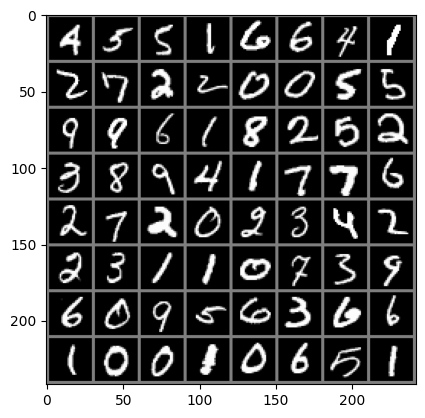

In [8]:
# 数据预览
images, labels = next(iter(dataloader_train))
print(images.shape)
img = make_grid(images)
img = img.numpy().transpose(1, 2, 0)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
img = img * std + mean
print([labels[i] for i in range(16)])
plt.imshow(img)
plt.show()


In [9]:
print(float(1/3))

0.3333333333333333
